# Importing Libraries

In [ ]:
!pip install pca
!pip install imbalanced-learn
!pip install pandas-profiling --upgrade

In [ ]:
from pca import pca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
from pandas_profiling import ProfileReport

# Loading and Exploring Data

In [ ]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
# Getting information about the dataset
df.info

<bound method DataFrame.info of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL 

In [ ]:
df.shape

(7043, 21)

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# Summary statistics of the dataset
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [ ]:
# Checking the data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# Droping the customer ID column because it is highly cardinal
df.drop("customerID",axis=1,inplace=True)

In [ ]:
# Checking for missing values
has_missing = df.isnull().any().any()
print(has_missing)
df.isnull().sum()

False


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Checking for duplicate rows
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicate rows:", num_duplicates)

# Dropping duplicate rows
df.drop_duplicates(inplace=True)

Number of duplicate rows: 22


The dataset does not has missing values nor duplicate rows as checked above.

In [ ]:
num_rows_with_tenure_zero = len(df[df['tenure'] == 0])
print("Number of rows with tenure value equal to zero:", num_rows_with_tenure_zero)
df.drop(df[df['tenure'] == 0].index, inplace=True)

Number of rows with tenure value equal to zero: 11


# Exploratory Data Analysis

##  Handling Catagorical Values

In [ ]:
# Creating a copy of the dataset for label encoding
# cols variable storing the column names of the object data type columns
cols=df.select_dtypes(include=object).columns
# Creating a copy of the dataset
label_encoded_train=df.copy()
# Creating an instance of LabelEncoder
le=LabelEncoder()

for i in cols:
    label_encoded_train[i]=le.fit_transform(label_encoded_train[i])

df_train=label_encoded_train.copy()
df_train.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2           29.85          2504      0  
1                 0              3           56.95          1465      0  
2                 1              3           53.85           156      1  
3                 0              0           42.30          1399      0  
4                 1              2           70.70           924      1

In [ ]:
df_train.shape

(7010, 20)

## Data Info

In [ ]:
profile = ProfileReport(df_train, title='Data detailed information', minimal=True, progress_bar=False)
profile.to_notebook_iframe()

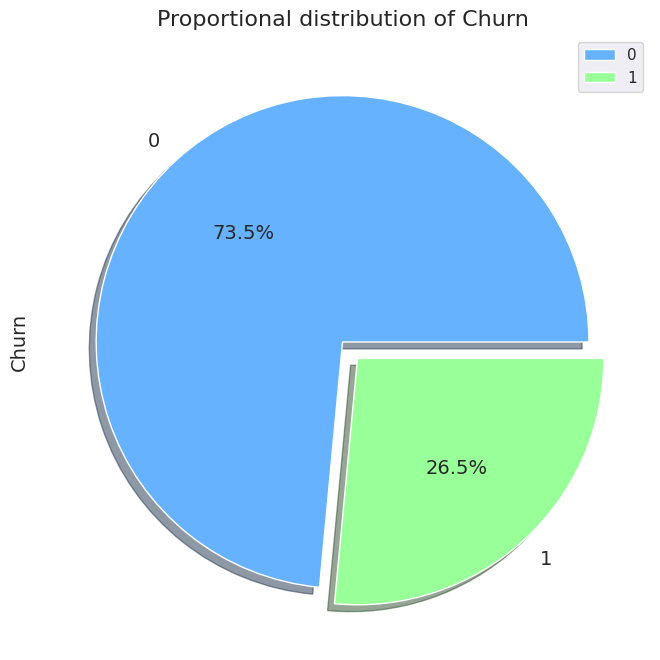

In [ ]:
colors = ['#66B2FF', '#99FF99']

df_train['Churn'].value_counts().plot(kind='pie', legend=True, explode=[0, 0.09], autopct="%3.1f%%", shadow=True, figsize=(8, 8), fontsize=14, colors=colors)

plt.title('Proportional distribution of Churn', fontsize=16)
plt.ylabel('Churn', fontsize=14)

plt.show()


## Box Plot (Checking for outliers in numerical data)

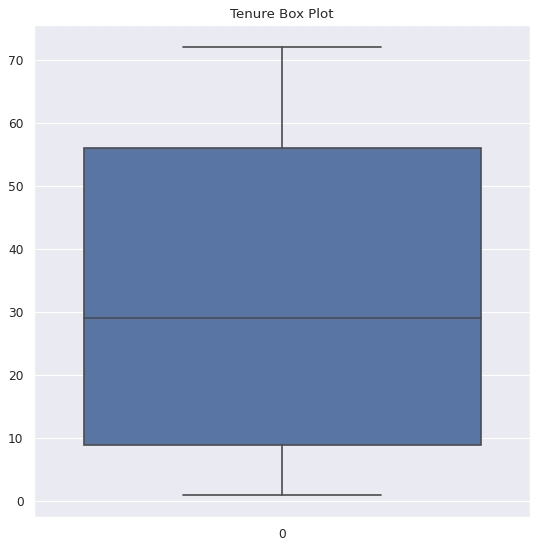

In [ ]:
plt.figure(figsize=(8,8), dpi= 80)
sns.boxplot(df_train['tenure'])
plt.title('Tenure Box Plot')
plt.show()

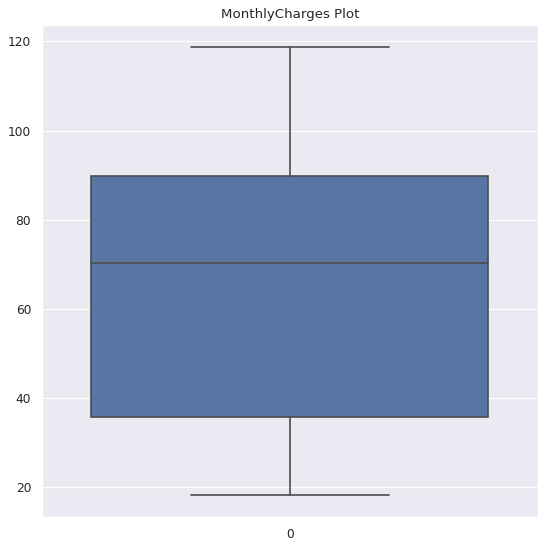

In [ ]:
plt.figure(figsize=(8,8), dpi= 80)
sns.boxplot(df_train['MonthlyCharges'])
plt.title('MonthlyCharges Plot')
plt.show()

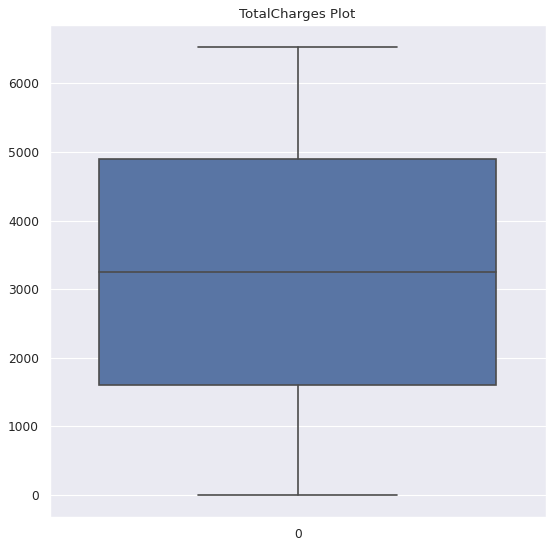

In [ ]:
plt.figure(figsize=(8,8), dpi= 80)
sns.boxplot(df_train['TotalCharges'])
plt.title('TotalCharges Plot')
plt.show()

## Correlation Heatmap

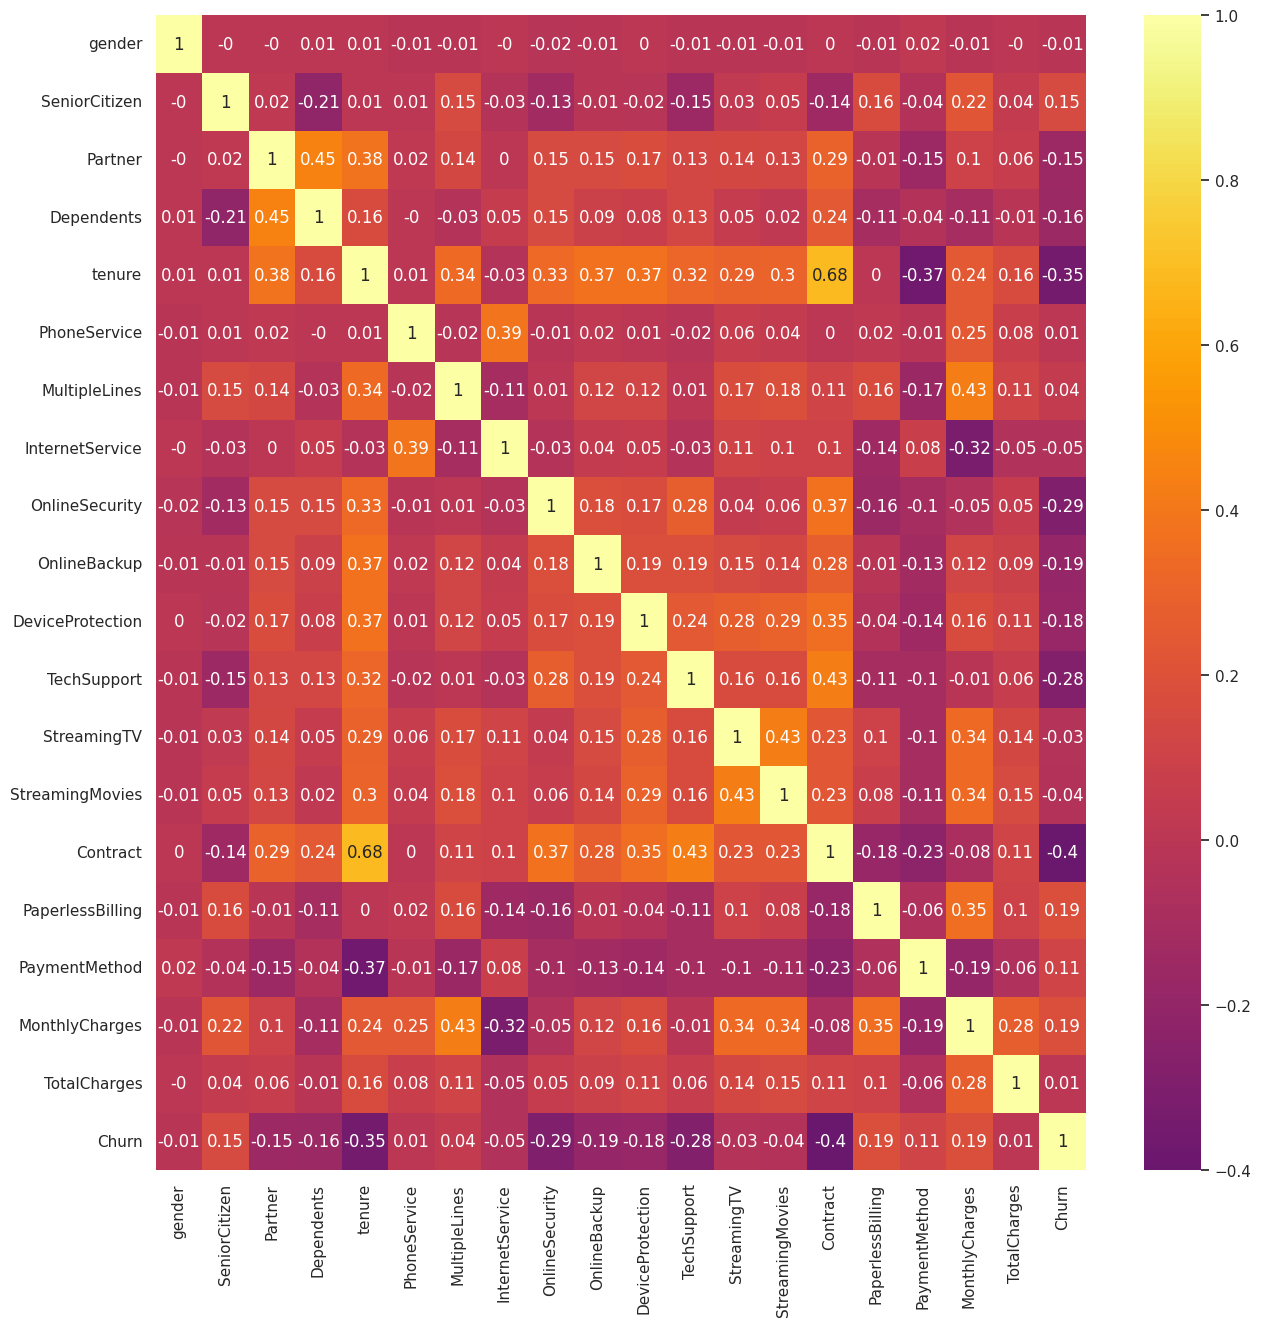

In [ ]:
num_col = df_train.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,15))
p=sns.heatmap(df_train[num_col].corr().round(2), annot=True,cmap='inferno',center=0)

**Feature Selection**

Gender:
-0.01 negligible corelation

SeniorCitizen:
0.15 weak +ve correlation

Partner:
-0.15 weak -ve correlation

Dependents:
-0.16 weak +ve correlation

tenure:
-0.35 weak +ve correlation

PhoneService:
0.01 negligible corelation

MultipleLines:
0.04 negligible corelation

InternetService:
-0.05 negligible corelation

OnlineSecurity:
-0.29 weak -ve correlation

OnlineBackup:
-0.2 weak -ve correlation

DeviceProtection:
-0.18 weak -ve correlation

TechSupport:
-0.28 weak -ve correlation

StreamingTV:
-0.04 negligible corelation

StreamingMovies:
-0.04 negligible corelation

Contract:
-0.4 strongest -ve correlation

PaperlessBilling:
0.19 weak +ve correlation

PaymentMethod:
0.11 weak +ve correlation

MonthlyCharges:
0.19 weak +ve correlation

TotalCharges:
0.01 negligible corelation

So as the results it is decided that **Contract, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Dependents ,MonthlyCharges, PaperlessBilling, PaymentMethod** are the most appropriate feactures for modeling.


## PCA_biplot

In a PCA biplot, the variables are represented as vectors, and the observations are represented as points on the scatter plot. The length and direction of the vectors represent the importance and direction of the variables in the principal component space, respectively. The location of the observations on the scatter plot shows their projection onto the principal components.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [20] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[datazets] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[pca] >Plot PC1 vs PC2 with loadings.


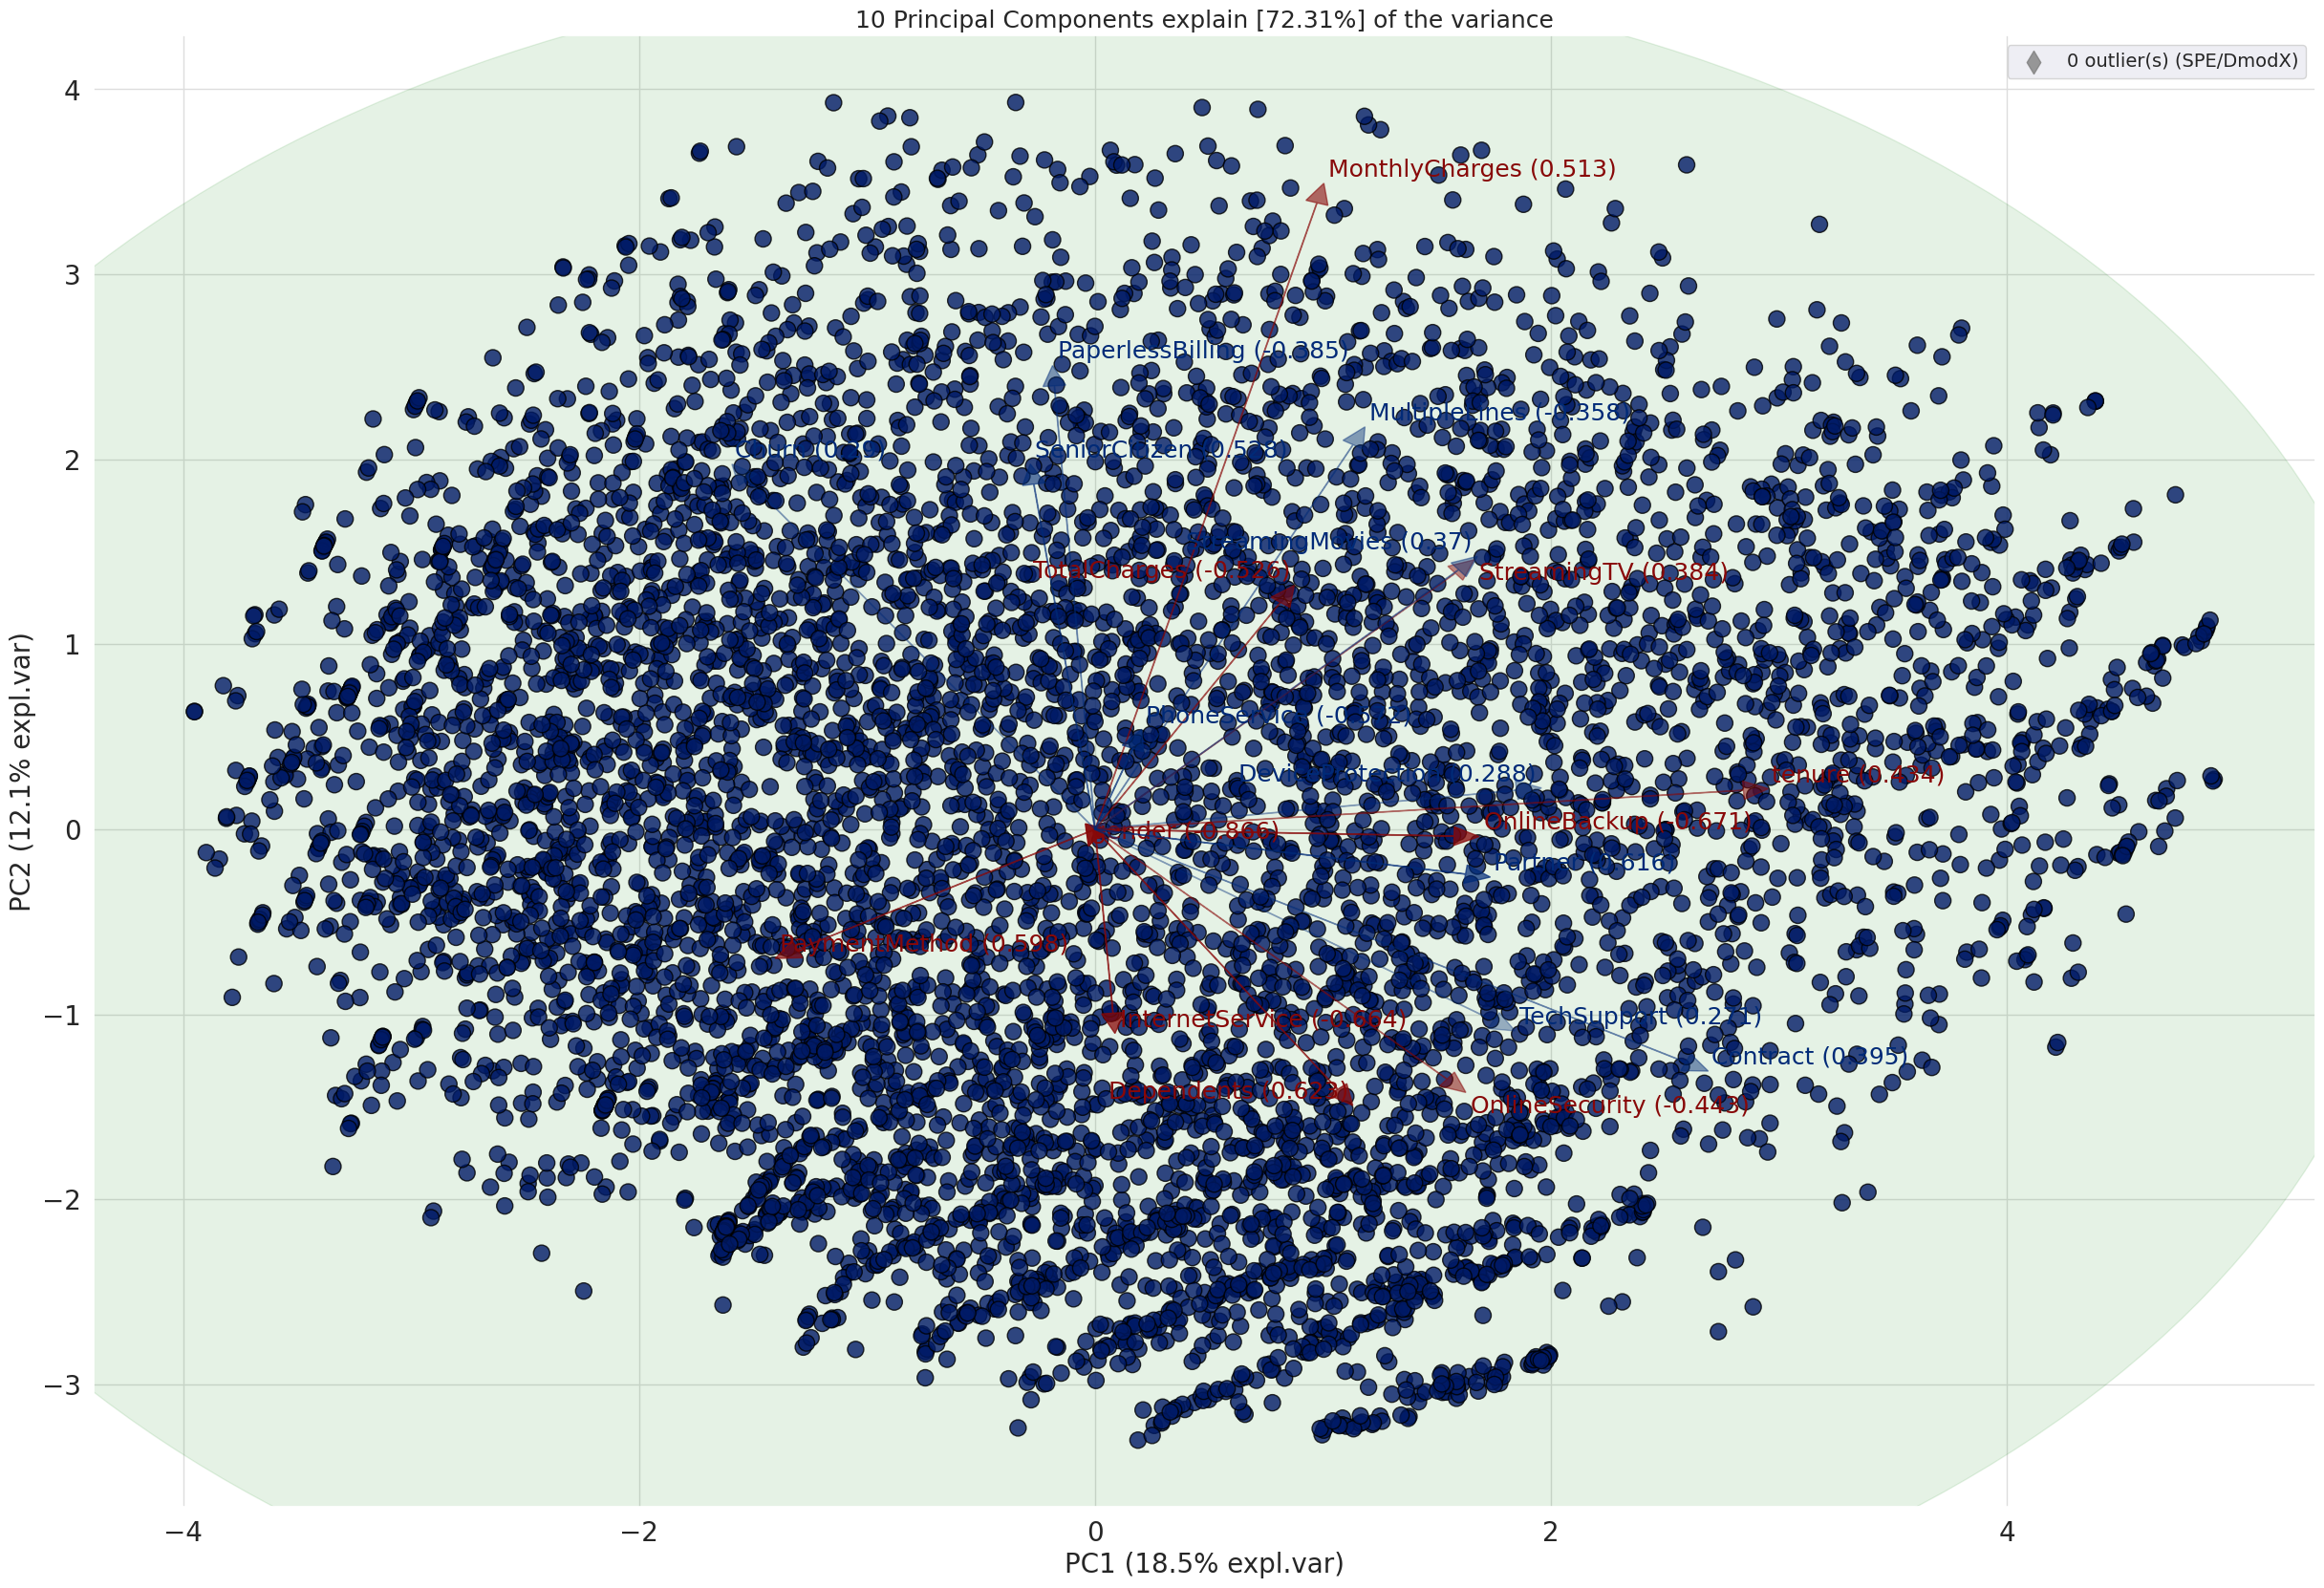

In [ ]:
model = pca(n_components=10, normalize=True)
results = model.fit_transform(df_train)
fig, ax = model.biplot(SPE=True, figsize=(30, 20))

In [ ]:
print(results)

{'loadings':         gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
PC1  -0.004266      -0.041755  0.254570    0.166012  0.433686      0.030062   
PC2  -0.013186       0.289993 -0.037922   -0.219223  0.032210      0.079344   
PC3   0.009031       0.016794  0.065840    0.025629  0.098556     -0.571867   
PC4   0.031092       0.003645  0.616343    0.623286  0.000278      0.158591   
PC5   0.106139      -0.328012  0.058996    0.258623 -0.191938     -0.378294   
PC6   0.477170       0.395895  0.073666   -0.096658  0.107085     -0.274629   
PC7  -0.865638       0.139406  0.068457    0.001223  0.008063     -0.192144   
PC8  -0.057801       0.527951  0.167711    0.011661 -0.012026     -0.179358   
PC9  -0.043972       0.253523  0.082172   -0.042280  0.011000     -0.041489   
PC10 -0.004412      -0.054939 -0.030866    0.013898  0.020301     -0.282471   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
PC1        0.173850         0.012810        0.2

Based on PCA result the best features will be

0    PC1            tenure  0.432661  best

1    PC2    MonthlyCharges  0.512251  best

2    PC3   InternetService -0.660506  best

3    PC4        Dependents  0.622214  best

4    PC5      PhoneService -0.391408  best

6    PC7            gender -0.863290  best

7    PC8     PaymentMethod  0.602487  best

8    PC9      OnlineBackup -0.664156  best

Based on the results of correrction and PCA the feature we will use for the model training are Following:
*   **tenure**
*   **MonthlyCharges**
*   OnlineBackup
*   Internet service
*   Dependents
*   Phone Service
*   **gender**
*   **PaymentMethod**
*   DeviceProtection
*   TechSupport
*   PaperlessBilling
*   Partner
*   **SeniorCitizen**
*   **Contract**
*   OnlineSecurity

# Spliting Data

## Splitng the unbalanecd dataset

In [ ]:
x=df_train[['tenure',
     'MonthlyCharges',
     'OnlineBackup',
     'InternetService',
     'Dependents',
     'PhoneService',
     'gender',
      'PaymentMethod',
      'DeviceProtection',
      'TechSupport',
      'PaperlessBilling',
      'Partner',
      'SeniorCitizen',
      'Contract',
      'OnlineSecurity']]
y=df_train[['Churn']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=42)


## Dataset Balancing

In [ ]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

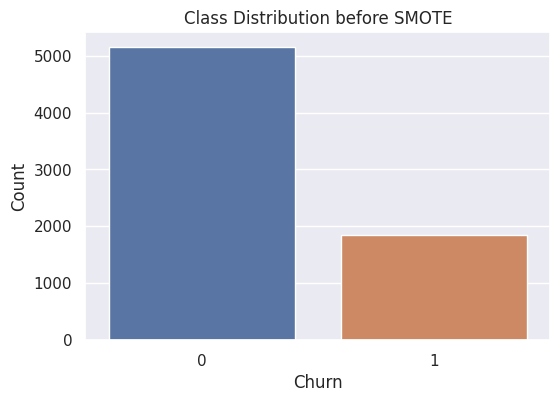

In [ ]:
class_counts = df_train['Churn'].value_counts()

# Create a bar plot of the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Class Distribution before SMOTE')
plt.show()

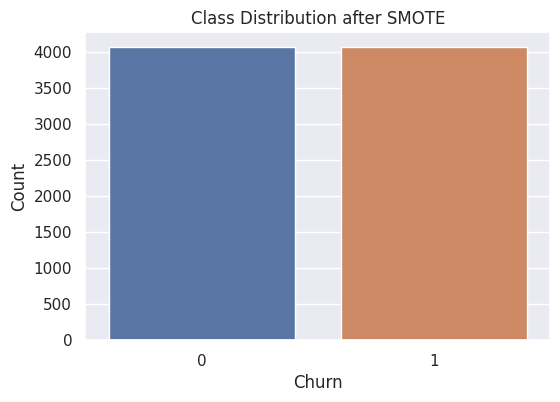

In [ ]:


resampled_data = pd.concat([x_train_resampled, y_train_resampled], axis=1)

# Count the occurrences of each class
class_counts = resampled_data['Churn'].value_counts()

# Create a bar plot of the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Class Distribution after SMOTE')
plt.show()

# Model Training

## Model Training with Dataset imbalance

### Logistic Regression

In [ ]:
LR_model=LogisticRegression(max_iter=1000)
LR_model.fit(x_train, y_train)
y_test_pred_LR=LR_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


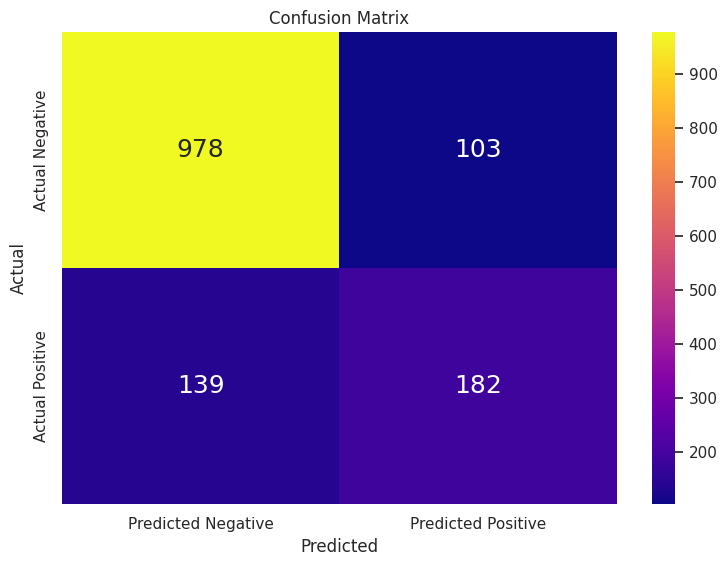

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_LR))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_LR)
precision = precision_score(y_test, y_test_pred_LR)
recall = recall_score(y_test, y_test_pred_LR)
f1 = f1_score(y_test, y_test_pred_LR)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.827389 │
├───────────┼──────────┤
│ Precision │ 0.638596 │
├───────────┼──────────┤
│ Recall    │ 0.566978 │
├───────────┼──────────┤
│ F1 Score  │ 0.60066  │
╘═══════════╧══════════╛


### Random Forest

In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(x_train, y_train)
y_test_pred_RF = RF_model.predict(x_test)

<ipython-input-220-a2fb840715aa>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train, y_train)


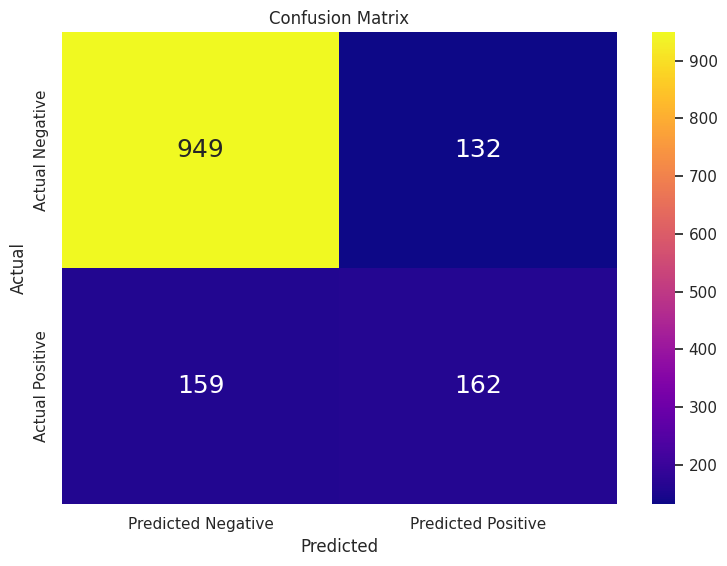

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_RF))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_RF)
precision = precision_score(y_test, y_test_pred_RF)
recall = recall_score(y_test, y_test_pred_RF)
f1 = f1_score(y_test, y_test_pred_RF)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.792439 │
├───────────┼──────────┤
│ Precision │ 0.55102  │
├───────────┼──────────┤
│ Recall    │ 0.504673 │
├───────────┼──────────┤
│ F1 Score  │ 0.526829 │
╘═══════════╧══════════╛


### SVC

In [ ]:
SVC_model = SVC()
SVC_model.fit(x_train, y_train)
y_test_pred_SVC = SVC_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


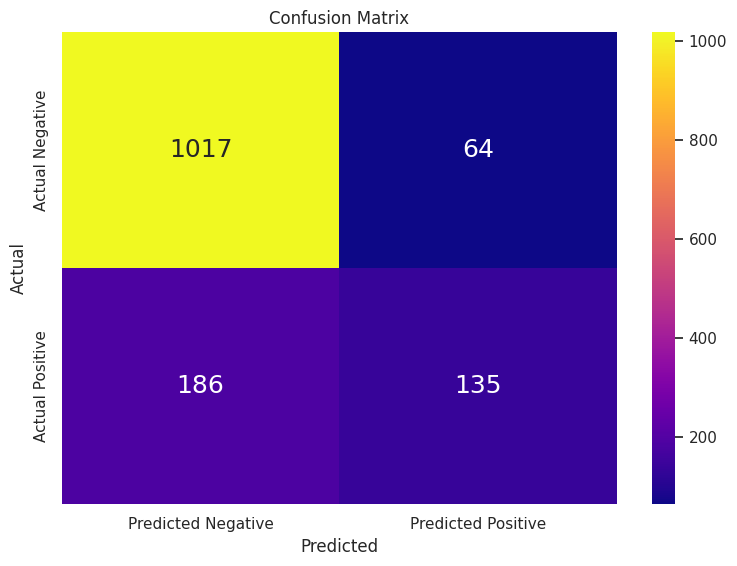

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_SVC))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_SVC)
precision = precision_score(y_test, y_test_pred_SVC)
recall = recall_score(y_test, y_test_pred_SVC)
f1 = f1_score(y_test, y_test_pred_SVC)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.821683 │
├───────────┼──────────┤
│ Precision │ 0.678392 │
├───────────┼──────────┤
│ Recall    │ 0.420561 │
├───────────┼──────────┤
│ F1 Score  │ 0.519231 │
╘═══════════╧══════════╛


## Model Training with Dataset balance

### Logistic Regression

In [ ]:
LR_model=LogisticRegression(max_iter=1000)
LR_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_LR=LR_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


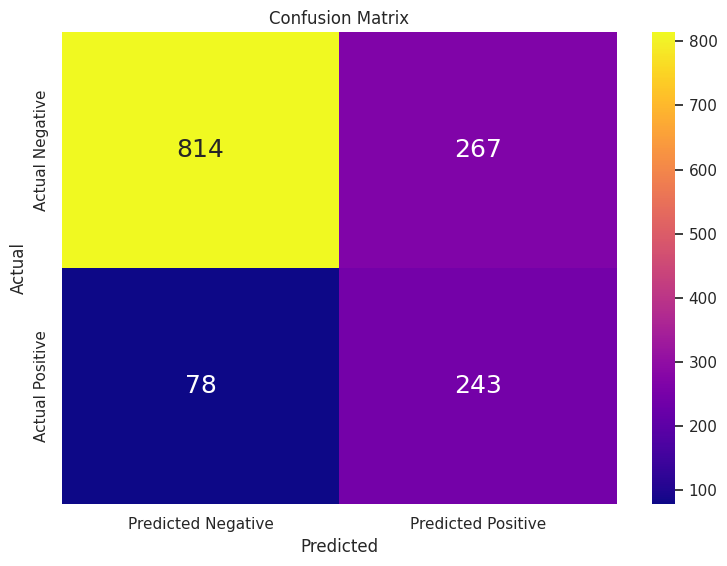

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_LR))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_LR)
precision = precision_score(y_test, y_test_pred_LR)
recall = recall_score(y_test, y_test_pred_LR)
f1 = f1_score(y_test, y_test_pred_LR)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.753923 │
├───────────┼──────────┤
│ Precision │ 0.476471 │
├───────────┼──────────┤
│ Recall    │ 0.757009 │
├───────────┼──────────┤
│ F1 Score  │ 0.584838 │
╘═══════════╧══════════╛


### Random Forest

In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_RF = RF_model.predict(x_test)

<ipython-input-229-99823d464be6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train_resampled, y_train_resampled)


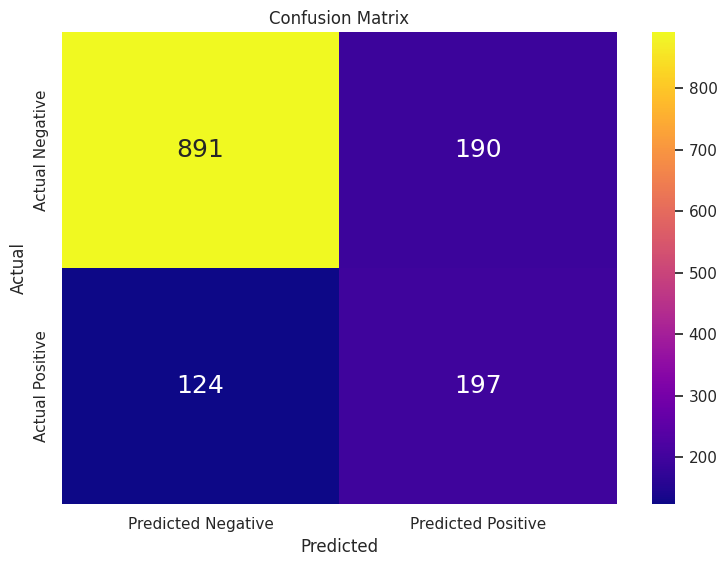

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_RF))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_RF)
precision = precision_score(y_test, y_test_pred_RF)
recall = recall_score(y_test, y_test_pred_RF)
f1 = f1_score(y_test, y_test_pred_RF)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.776034 │
├───────────┼──────────┤
│ Precision │ 0.509044 │
├───────────┼──────────┤
│ Recall    │ 0.613707 │
├───────────┼──────────┤
│ F1 Score  │ 0.556497 │
╘═══════════╧══════════╛


### SVC

In [ ]:
SVC_model = SVC()
SVC_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_SVC = SVC_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


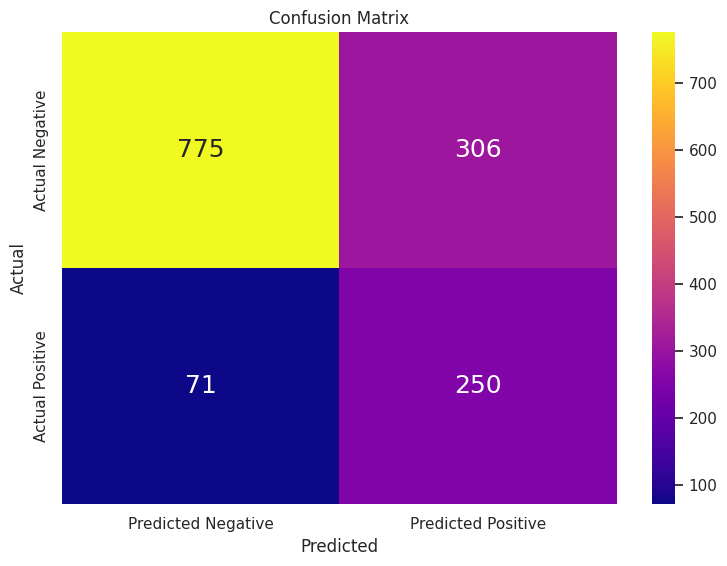

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_SVC))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_SVC)
precision = precision_score(y_test, y_test_pred_SVC)
recall = recall_score(y_test, y_test_pred_SVC)
f1 = f1_score(y_test, y_test_pred_SVC)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.731098 │
├───────────┼──────────┤
│ Precision │ 0.44964  │
├───────────┼──────────┤
│ Recall    │ 0.778816 │
├───────────┼──────────┤
│ F1 Score  │ 0.570125 │
╘═══════════╧══════════╛


# Optimization

## For Logistic Regression

### Dataset Imbalance

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 0.5, 1.0, 5.0, 10.0],
    "solver": ["liblinear", "saga"]
}

logreg = LogisticRegression()

grid_cv = GridSearchCV(logreg, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train, y_train)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Best Parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC Score: 0.8393273461260984


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### For Dataset Balanced

In [ ]:
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 0.5, 1.0, 5.0, 10.0],
    "solver": ["liblinear", "saga"]
}

logreg = LogisticRegression()

grid_cv = GridSearchCV(logreg, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train_resampled, y_train_resampled)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Best Parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC Score: 0.8664735416786185


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## For Random Forest

### Dataset Imbalance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

rf = RandomForestClassifier(random_state=42)

grid_cv = GridSearchCV(rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train, y_train)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Best ROC AUC Score: 0.8414814021652506


### Dataset Balanced

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

rf = RandomForestClassifier(random_state=42)

grid_cv = GridSearchCV(rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train_resampled, y_train_resampled)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC Score: 0.9195130877111101


## SVC

### Dataset Imbalance

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1.0, 10.0],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

svc = SVC(random_state=42)

grid_cv = GridSearchCV(svc, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train, y_train)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}
Best ROC AUC Score: 0.8355099091684556


### Dataset balanced

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1.0, 10.0],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

svc = SVC(random_state=42)

grid_cv = GridSearchCV(svc, param_grid, scoring="roc_auc", n_jobs=-1, cv=5)
grid_cv.fit(x_train_resampled, y_train_resampled)

# Return set of parameters with the best performance
best_params = grid_cv.best_params_

# Return the performance metric score
best_score = grid_cv.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}
Best ROC AUC Score: 0.914008767476189


# Model Traing after optimization

## Model Training with Dataset imbalance

### Logistic Regression

In [ ]:
LR_model=LogisticRegression(max_iter=1000, C=0.5, penalty='l2', solver='liblinear')
LR_model.fit(x_train, y_train)
y_test_pred_LR=LR_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


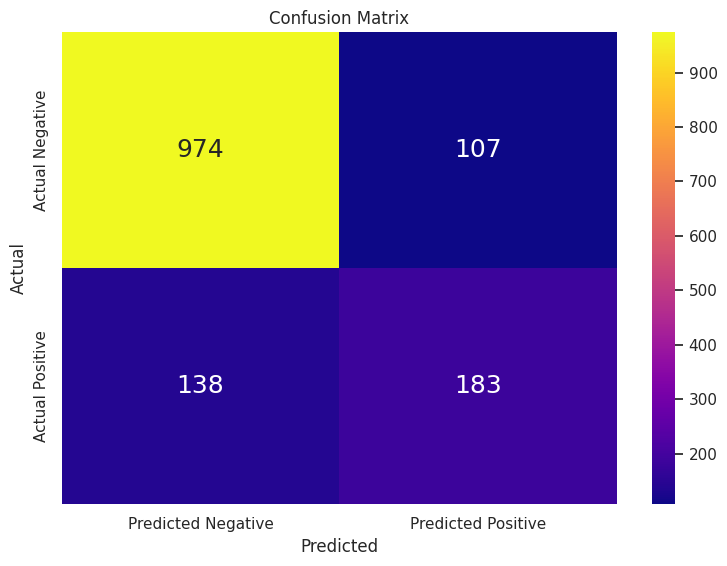

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_LR))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_LR)
precision = precision_score(y_test, y_test_pred_LR)
recall = recall_score(y_test, y_test_pred_LR)
f1 = f1_score(y_test, y_test_pred_LR)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.82525  │
├───────────┼──────────┤
│ Precision │ 0.631034 │
├───────────┼──────────┤
│ Recall    │ 0.570093 │
├───────────┼──────────┤
│ F1 Score  │ 0.599018 │
╘═══════════╧══════════╛


### Random Forest

In [ ]:
RF_model = RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=4, min_samples_split=10, n_estimators=500, random_state=42)
RF_model.fit(x_train, y_train)
y_test_pred_RF = RF_model.predict(x_test)

<ipython-input-202-6c3021c00c96>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


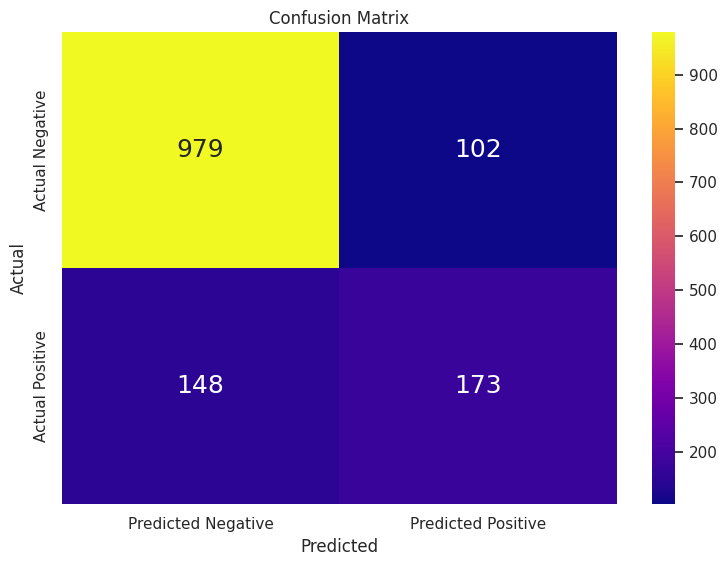

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_RF))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_RF)
precision = precision_score(y_test, y_test_pred_RF)
recall = recall_score(y_test, y_test_pred_RF)
f1 = f1_score(y_test, y_test_pred_RF)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.821683 │
├───────────┼──────────┤
│ Precision │ 0.629091 │
├───────────┼──────────┤
│ Recall    │ 0.538941 │
├───────────┼──────────┤
│ F1 Score  │ 0.580537 │
╘═══════════╧══════════╛


### SVC

In [ ]:
SVC_model = SVC(C=10.0, gamma='scale', kernel='linear')
SVC_model.fit(x_train, y_train)
y_test_pred_SVC = SVC_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


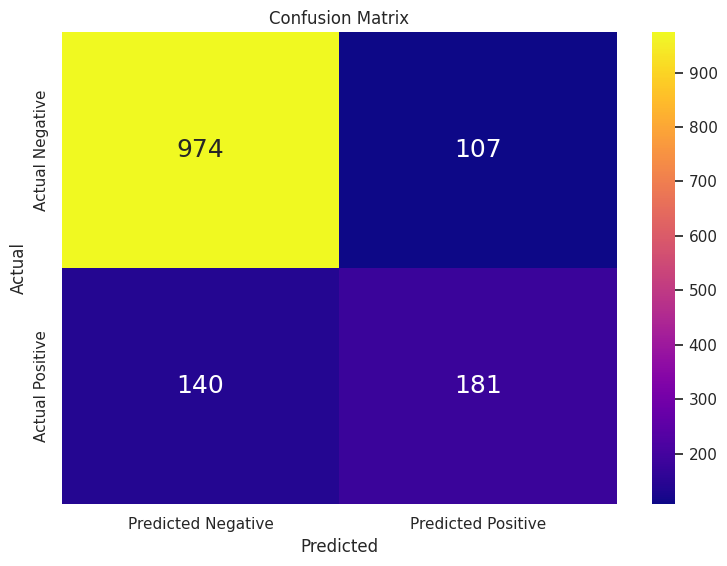

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_SVC))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_SVC)
precision = precision_score(y_test, y_test_pred_SVC)
recall = recall_score(y_test, y_test_pred_SVC)
f1 = f1_score(y_test, y_test_pred_SVC)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.823823 │
├───────────┼──────────┤
│ Precision │ 0.628472 │
├───────────┼──────────┤
│ Recall    │ 0.563863 │
├───────────┼──────────┤
│ F1 Score  │ 0.594417 │
╘═══════════╧══════════╛


## Model Training with Dataset balance

### Logistic Regression

In [ ]:
LR_model=LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear')
LR_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_LR=LR_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


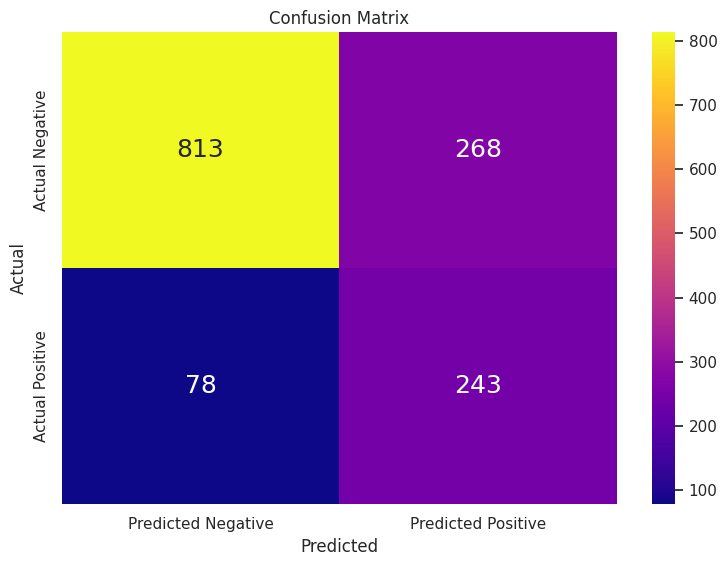

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_LR))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_LR)
precision = precision_score(y_test, y_test_pred_LR)
recall = recall_score(y_test, y_test_pred_LR)
f1 = f1_score(y_test, y_test_pred_LR)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.75321  │
├───────────┼──────────┤
│ Precision │ 0.475538 │
├───────────┼──────────┤
│ Recall    │ 0.757009 │
├───────────┼──────────┤
│ F1 Score  │ 0.584135 │
╘═══════════╧══════════╛


### Random Forest

In [ ]:
RF_model = RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42)
RF_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_RF = RF_model.predict(x_test)

<ipython-input-211-537753010d4c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train_resampled, y_train_resampled)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


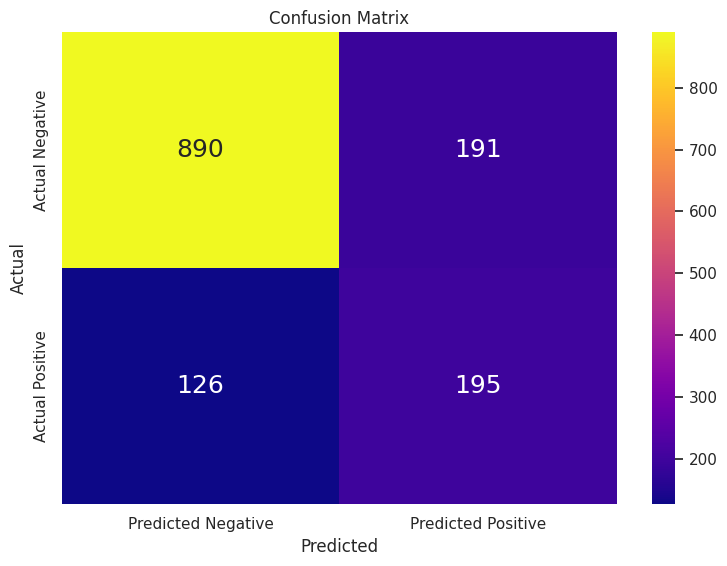

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_RF))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_RF)
precision = precision_score(y_test, y_test_pred_RF)
recall = recall_score(y_test, y_test_pred_RF)
f1 = f1_score(y_test, y_test_pred_RF)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.773894 │
├───────────┼──────────┤
│ Precision │ 0.505181 │
├───────────┼──────────┤
│ Recall    │ 0.607477 │
├───────────┼──────────┤
│ F1 Score  │ 0.551627 │
╘═══════════╧══════════╛


### SVC

In [ ]:
SVC_model = SVC(C=10.0, gamma='scale', kernel='rbf')
SVC_model.fit(x_train_resampled, y_train_resampled)
y_test_pred_SVC = SVC_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


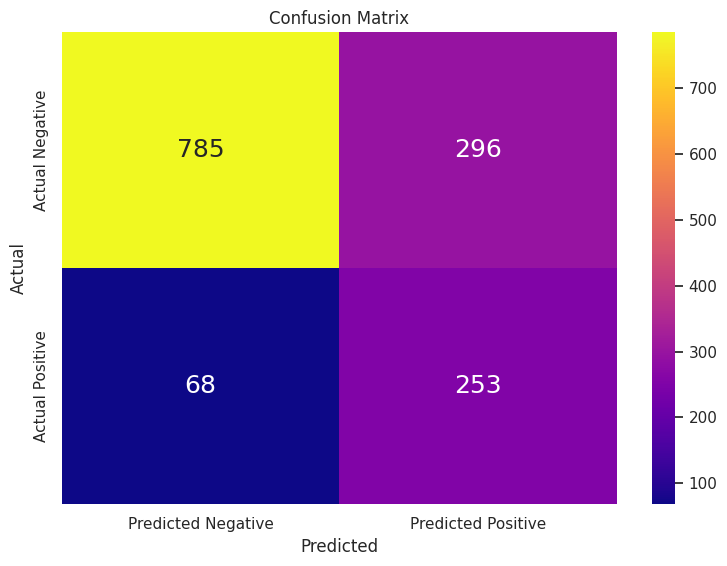

In [ ]:
confusion_mat=pd.DataFrame(confusion_matrix(y_test, y_test_pred_SVC))
confusion_mat.index=['Actual Negative', 'Actual Positive']
confusion_mat.columns=['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='plasma', fmt='g')
# Add labels, title, and adjust layout
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# Display the confusion matrix
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred_SVC)
precision = precision_score(y_test, y_test_pred_SVC)
recall = recall_score(y_test, y_test_pred_SVC)
f1 = f1_score(y_test, y_test_pred_SVC)
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]
print(tabulate(table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Accuracy  │ 0.740371 │
├───────────┼──────────┤
│ Precision │ 0.460838 │
├───────────┼──────────┤
│ Recall    │ 0.788162 │
├───────────┼──────────┤
│ F1 Score  │ 0.581609 │
╘═══════════╧══════════╛
